<a href="https://colab.research.google.com/github/roliveira15/Data_Science_Sales_Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Carregando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2) Importando o dataFrame

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


### 3) Importando Dataframe

In [3]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
df = pd.read_csv('https://raw.githubusercontent.com/roliveira15/Data_Science_Sales_Forecast/main/base.csv', sep = ';')
df.dtypes

tipo_frete                      object
peso                            object
valor_total_pedido              object
data                            object
abreviatura_uf                  object
regiao                          object
grupo_gerencial_produto         object
conta_numero_pedido_vendedor     int64
dtype: object

### 4) Converter o peso e o valor em float

Por padrão todas as variáveis do tipo string são armazenadas como object por esse motivo toda vez que tentamos modifcar de object para str, quando geramos o dtypes, as variáveis permanecem object. https://statisticsglobe.com/convert-object-data-type-string-pandas-dataframe-column-python





In [4]:
df['peso'] = df['peso'].str.replace(',','.').astype(float)
df['valor_total_pedido'] = df['valor_total_pedido'].str.replace(',','.').astype(float)
df['data'] = pd.to_datetime(df['data'])

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
dtype: object

###5) Criar uma coluna de Ano e mês

In [5]:
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
ano                                      int64
mes                                      int64
dtype: object

### 6) Criando estrutura para gerar gráfico de estruturas por ano, mes em função de peso e valor_total_pedido 

In [6]:
groupStructures = df.groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum()
groupStructures = groupStructures.round({'valor_total_pedido': 0,'peso': 0}).groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum().reset_index()
groupStructures.loc[(groupStructures['valor_total_pedido'] > 0) & (groupStructures['data'] >= '2020-09-01')]


,grupo_gerencial_produto,ano,mes,data,tipo_frete,regiao,abreviatura_uf,peso,valor_total_pedido,conta_numero_pedido_vendedor
3,AUTOMACAO,2020,9,2020-09-10,CIF,Sudeste,ES,1343.0,79000.0,1
5,AUTOMACAO,2020,11,2020-11-08,CIF,Sudeste,ES,811.0,56550.0,1
6,AUTOMACAO,2021,1,2021-01-04,CIF,Sudeste,ES,3830.0,333060.0,1
7,AUTOMACAO,2021,1,2021-01-05,CIF,Nordeste,RN,8845.0,610800.0,1
8,AUTOMACAO,2021,3,2021-03-08,CIF,Sudeste,SP,2542.0,2052312.0,1
...,...,...,...,...,...,...,...,...,...,...
4558,UNIVERSAL,2023,5,2023-05-15,FOB,Sudeste,ES,6628.0,10605.0,1
4559,UNIVERSAL,2023,6,2023-06-02,FOB,Sudeste,ES,8721.0,13954.0,1
4560,UNIVERSAL,2023,6,2023-06-04,FOB,Sudeste,ES,4955.0,7928.0,1
4561,UNIVERSAL,2023,7,2023-07-03,FOB,Sudeste,ES,8695.0,13912.0,1


6.1) Criando gráfico por estrutura


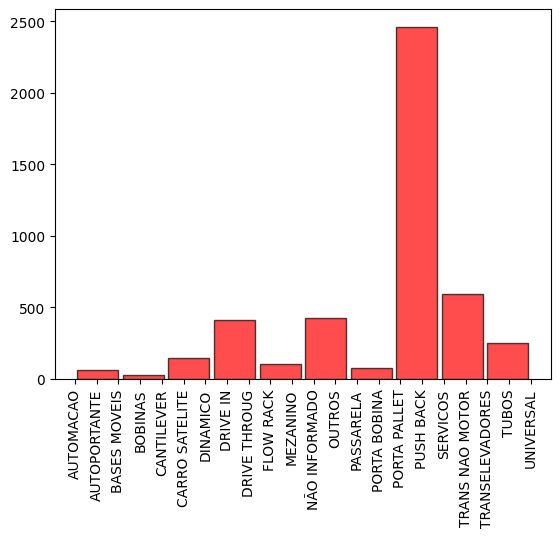

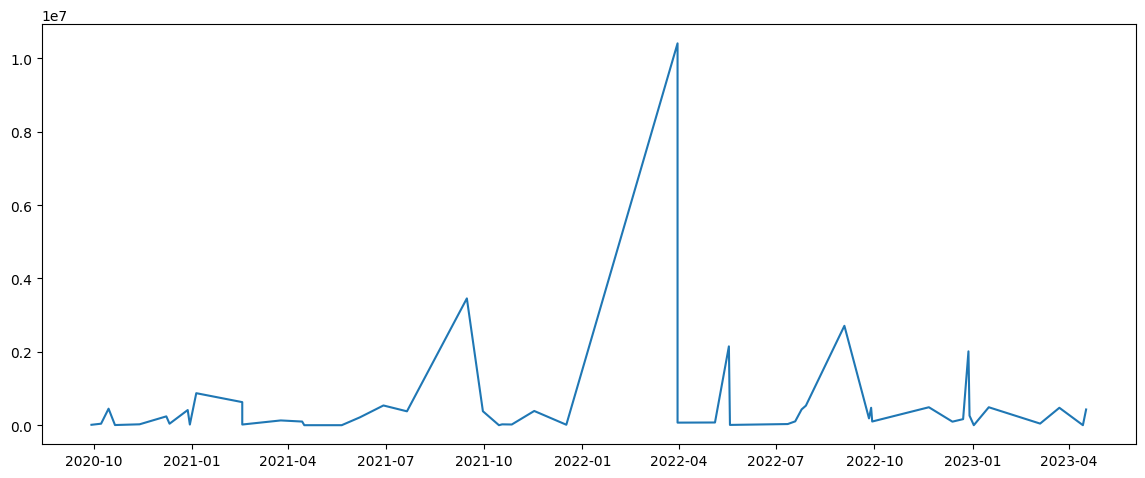

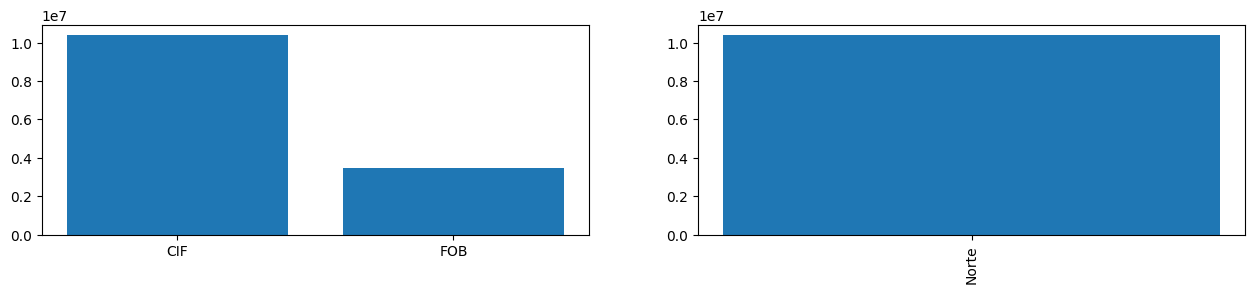

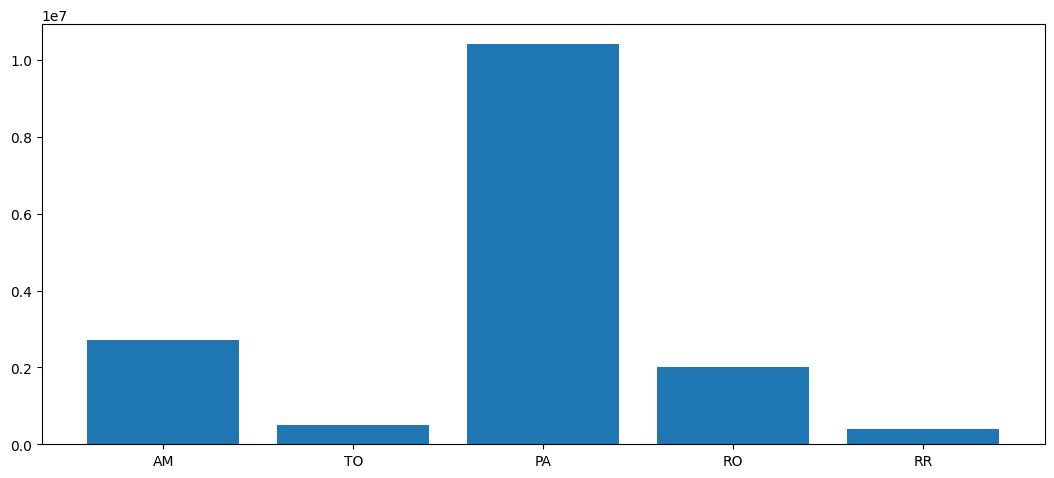

In [13]:
#def plot_color_label_before(data, axisx, axisy,target):
#    colors = ['red' if word == target else 'blue' for word in data[axisx]]
#    bars = plt.bar(x=data[axisx], height=data[axisy], color=colors, alpha=1)
#    plt.xticks(rotation=90)

#Gráfico de barras de todas estruturas de 2020 até 2023
#plot_color_label_before(groupStructures,'grupo_gerencial_produto','valor_total_pedido' ,'PORTA PALLET')


'''
                                  PORTA PALETE
'''
#Gráfico de barras de 
PP = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-09-01') & (groupStructures['data'] < '2023-09-01') & (groupStructures['regiao'] == 'Norte')]

plt.hist(groupStructures['grupo_gerencial_produto'], rwidth=0.9, color='red', alpha=0.7, edgecolor='black')
plt.xticks(rotation=90)

plt.figure(figsize = ((48, 12)))
#Anual
plt.subplot(2, 3, 3)
plt.plot(PP['data'],PP['valor_total_pedido'])
plt.show()

plt.figure(figsize = ((24, 6)))
#Tipo de frete
plt.subplot(2, 3, 1)
plt.bar(PP['tipo_frete'], PP['valor_total_pedido'])
#Região
plt.subplot(2, 3, 2)
plt.bar(PP['regiao'], PP['valor_total_pedido'])
plt.xticks(rotation=90)
#Estado
plt.figure(figsize = ((44, 12)))
plt.subplot(2, 3, 4)
plt.bar(PP['abreviatura_uf'],PP['valor_total_pedido'])
plt.show()




Realizar a plotagem de todos os grupos para entender o comportadomento dos gráficos

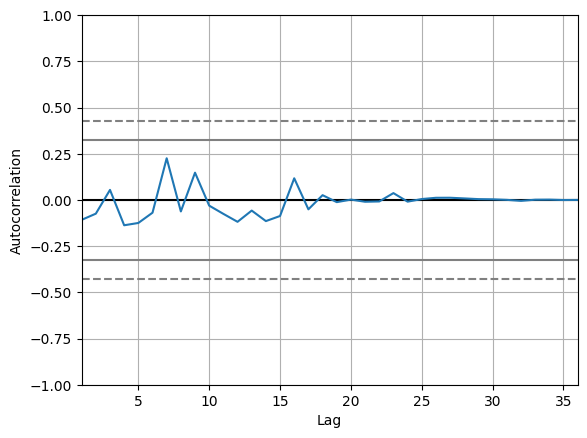

In [27]:
autocorrelation_plot(groupStructures['valor_total_pedido'].loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2021-01-01') & (groupStructures['data'] < '2023-01-01') & (groupStructures['regiao'] == 'Norte')])
plt.show()

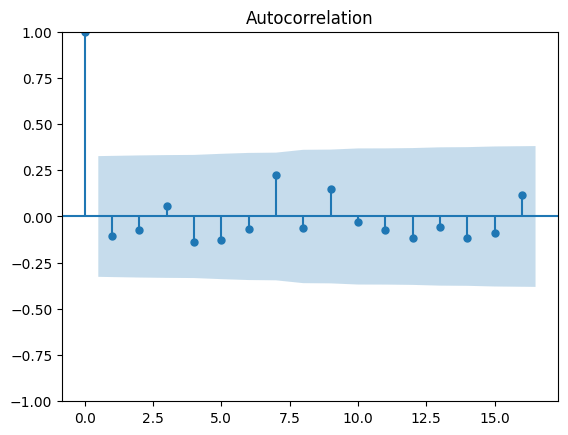

In [26]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

    
plot_acf(groupStructures['valor_total_pedido'].loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2021-01-01') & (groupStructures['data'] < '2023-01-01') & (groupStructures['regiao'] == 'Norte')])
plt.show()